In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr
from tqdm import tqdm

In [2]:
RPKM_PATH = "/data/yosef3/scratch/ruchir/data/geuvadis/analysis_results/GD660.GeneQuantRPKM.txt.gz"
METADATA_PATH = "/data/yosef3/users/ruchir/pgp_uq/data/E-GEUV-1.sdrf.txt"

In [3]:
rpkm_df = pd.read_csv(RPKM_PATH, sep="\t", index_col=0)

In [4]:
def subset_to_experiments_in_metadata(counts_df: pd.DataFrame) -> pd.DataFrame:
    meta_df = pd.read_csv(METADATA_PATH, sep="\t", index_col=0)
    experiments = list(sorted(set(meta_df["Assay Name"])))
    counts_df = pd.concat((counts_df.iloc[:, :3], counts_df[experiments]), axis=1)
    counts_df.columns = [c.split(".")[0] for c in counts_df.columns]
    return counts_df


def convert_to_tpm(rpkm_df: pd.DataFrame) -> pd.DataFrame:
    tpm_df = rpkm_df.copy()
    for c in tpm_df.columns[3:]:
        tpm_df[c] = tpm_df[c] / tpm_df[c].sum() * 1e6
    return tpm_df


def remove_low_expression_genes(counts_df: pd.DataFrame) -> pd.DataFrame:
    # Remove genes with 0 counts in >= 50% samples
    n_zero_samples = (counts_df.iloc[:, 3:] == 0).sum(axis=1)
    frac_zero_samples = n_zero_samples / (counts_df.shape[1] - 3)
    counts_df = counts_df.loc[frac_zero_samples < 0.5].copy()
    return counts_df

In [5]:
rpkm_df = subset_to_experiments_in_metadata(rpkm_df)
tpm_df = convert_to_tpm(rpkm_df)
tpm_df = remove_low_expression_genes(tpm_df)

In [6]:
rpkm_df = pd.read_csv("../rpkm/unnormalized_rpkm_processed.csv", index_col=0)
assert set(rpkm_df.columns) == set(tpm_df.columns)
assert set(rpkm_df.index) == set(tpm_df.index)

  0%|          | 9/23722 [00:00<04:32, 86.96it/s]

100%|██████████| 23722/23722 [01:34<00:00, 252.18it/s]


<Axes: ylabel='Density'>

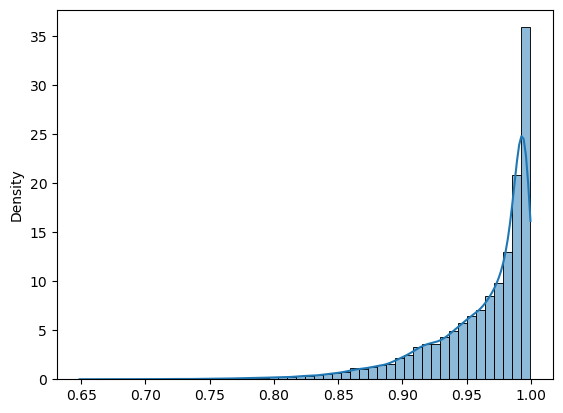

In [7]:
# Compute correlations between RPKM and TPM
corrs = {}
samples = rpkm_df.columns[3:]
for g in tqdm(tpm_df.index):
    corrs[g] = spearmanr(rpkm_df.loc[g, samples], tpm_df.loc[g, samples])[0]

sns.histplot(
    x=list(corrs.values()),
    bins=50,
    kde=True,
    stat="density",
)

In [8]:
tpm_df.to_csv("tpm.csv.gz", index=True)